
This notebook is a companion to the Applied XAI talk at the Montreal DSDT Meetup. A link to the slides will be added when available.

The first part of the notebook uses the saliency library.The code is based on the [original tutorial](https://github.com/PAIR-code/saliency) from the People and AI research team.   
 We will explore the following techniques, alongside with the `SmoothGrad` augmentation:

*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   XRAI ([paper](https://arxiv.org/abs/1906.02825))  


The second section of the notebook covers the implementation of integrated gradients from scratch following [this tutorial.](https://keras.io/examples/vision/integrated_gradients/) 

# Explainable AI with gradient based methods and saliency package. 


In [ ]:
# Start by installing the saliency package
!pip install saliency tensorflow


In [2]:
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
from mpl_toolkits.axes_grid1 import make_axes_locatable
import saliency.core as saliency
from tensorflow.keras.applications.vgg16 import decode_predictions

%matplotlib inline

### Utility methods

In [3]:
#@title Boilerplate methods - do not skip this cell
#@markdown Code hidden to make the notebook shorter.  


#@markdown Double click to reveal the code and explore the definitions. 
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
  if ax is None:
    fig, ax = P.subplots()
  else:
    fig = ax.figure
  
  P.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
  fig.colorbar(im, cax=cax, orientation='vertical')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224,224))
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

### Loading the VGG16 model with ImageNet weights

In [4]:
m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
conv_layer = m.get_layer('block5_conv3') # last conv layer of vgg16
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output]) #define model with the functionnal API 

553467904/553467096 [==============================] - 6s 0us/step


In [5]:
# Get the ImageNet actual labels to understand what indexes refer to 
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


`call_model_function` is how we pass inputs to our model and receive outputs necessary to computer saliency masks. This function is defined to be used with all the methods, but if you know which saliency method you will be using, then you can simplfy it. 
The description of this method and necessary outputs is in the base CoreSaliency description, as well as separately for each method.

In [6]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

### Load an image and infer

grey fox


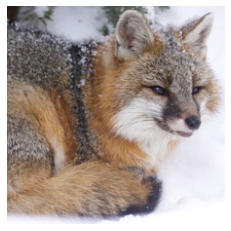

In [10]:
#LoadImage
fox = LoadImage('../Data/fox.jpg')
im_fox = PreprocessImage(fox)
ShowImage(fox)
# predict 

_, predictions = model(np.array([im_fox]))
prediction_class = np.argmax(predictions[0])
class_label = imagenet_labels[prediction_class+1]
call_model_args = {class_idx_str: prediction_class}
print(class_label)

### Integrated Gradients & SmoothGrad

For saliency methods that compute gradients along a path (e.g. Integrated Gradients), we can pass a batch_size parameter, which will batch the different steps along the path together so that the model isn't called for each individual step. When using this parameter, be sure that you are not overloading memory, as a very large batch size could crash the program.

In [12]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Define your baseline
baseline = np.zeros(im_fox.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_ig_mask = integrated_gradients.GetMask(
  im_fox, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_ig_mask = integrated_gradients.GetSmoothedMask(
  im_fox, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_ig_mask)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_ig_mask)

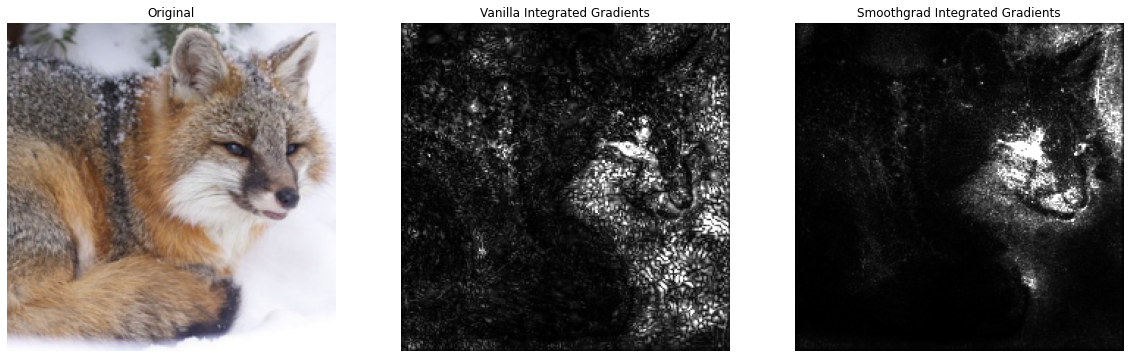

In [13]:

# Set up matplot lib figures.
ROWS = 2
COLS = 3
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(fox, title='Original', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### XRAI Full and Fast

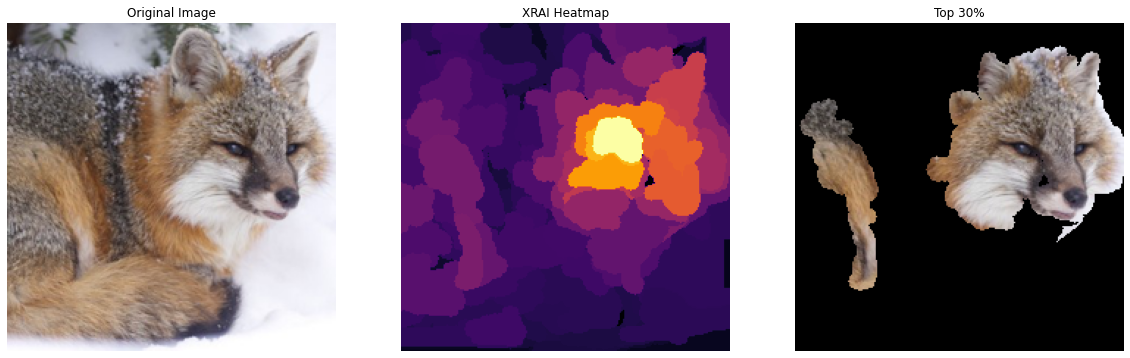

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im_fox, call_model_function, call_model_args, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(fox, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 70)
im_mask = np.array(fox)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

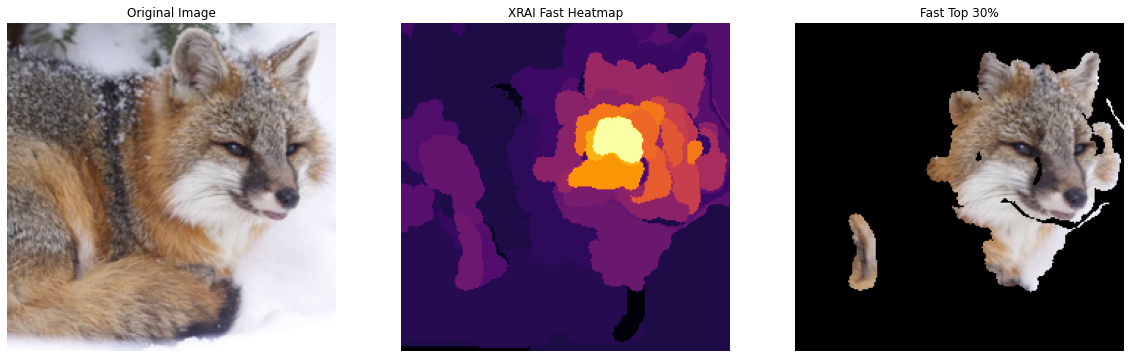

In [ ]:
# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result. 
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(im_fox, call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(fox, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_fast, title='XRAI Fast Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_fast > np.percentile(xrai_attributions_fast, 70)
im_mask = np.array(fox)
im_mask[~mask] = 0
ShowImage(im_mask, 'Fast Top 30%', ax=P.subplot(ROWS, COLS, 3))

# Keras integrated gradient implementation

In [14]:
def integrated_gradients(img, label, steps=50):
  '''Returns attributions for the prediction label based
     on integrated gradients at the image.

     Specifically, the method returns the dot product of the image
     and the average of the gradients of the prediction label (w.r.t.
     the image) at uniformly spaced scalings of the provided image.

     The provided image must of shape (224, 224, 3), which is 
     also the shape of the returned attributions tensor.
  ''' 

  # Obtain the tensor representing the softmax output of the provided label.
  t_output = output_label_tensor(label) # shape: scalar
  t_grad = tf.gradients(t_output, T('input'))[0]

  scaled_images = [(float(i)/steps)*img for i in range(1, steps+1)]
  # Compute the gradients of the scaled images
  grads = run_network(sess, t_grad, scaled_images)

  # Average the gradients of the scaled images and dot product with the original
  # image
  return img*np.average(grads, axis=0)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16


In [16]:
# Size of the input image
img_size = (224, 224, 3)

# Load VGG16 model with imagenet weights
model = vgg16.VGG16(weights='imagenet')

In [17]:
img_path = ('../Data/fox.jpg')

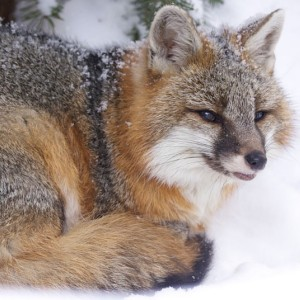

In [18]:
display(Image(img_path, width= 200, height= 200))

In [19]:
def get_img_array(img_path, size=(224,224)):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1,224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array



In [20]:

def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads

In [21]:
def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = vgg16.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)
  

class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self, attributions, percentage=90, connected_component_structure=np.ones((3, 3))
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.measurements.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        gradients,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img1 = np.copy(image)
        img2 = np.copy(image)

        # 2. Process the normal gradients
        grads_attr = self.process_grads(
            image=img1,
            attributions=gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 3, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(grads_attr.astype(np.uint8))
        ax[2].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Input")
        ax[1].set_title("Normal gradients")
        ax[2].set_title("Integrated gradients")
        plt.show()


40960/35363 [==================================] - 0s 0us/step
Predicted: tf.Tensor(280, shape=(), dtype=int64) [('n02120505', 'grey_fox', 0.9222343)]


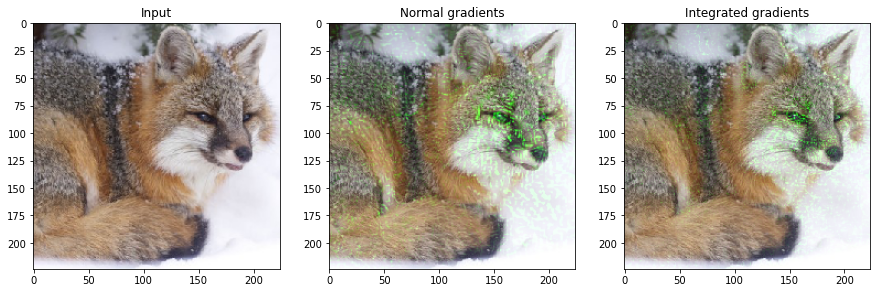

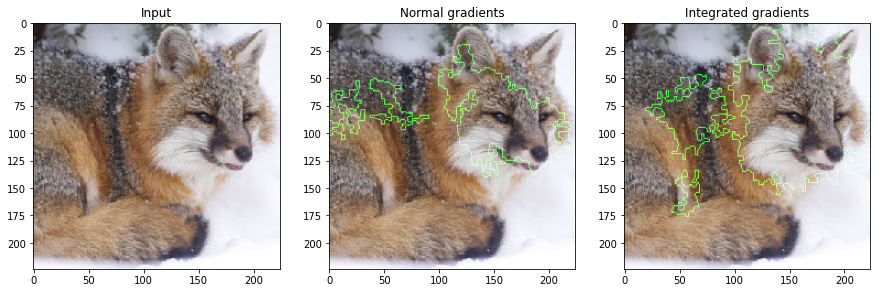

In [22]:

# 1. Convert the image to numpy array
img = get_img_array(img_path)

# 2. Keep a copy of the original image
orig_img = np.copy(img[0]).astype(np.uint8)

# 3. Preprocess the image
img_processed = tf.cast(vgg16.preprocess_input(img), dtype=tf.float32)

# 4. Get model predictions
preds = model.predict(img_processed)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", top_pred_idx, vgg16.decode_predictions(preds, top=1)[0])

# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(img_processed, top_pred_idx=top_pred_idx)

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=95,
    clip_below_percentile=28,
    morphological_cleanup=True,
    outlines=True,
)